# Algorithmic Fairness and Interpretability: Assignment
---
Goal of the notebook: Steps 1 to 10 of the assignment

## Dependencies and path
Adjust the argument in `sys.path.append` to align with your specific requirements.

In [1]:
import pandas as pd 
import numpy as np
import os
import sys

%load_ext autoreload
%autoreload 2

# Change according to the path where the data is
os.chdir('C:/Users/dorab/OneDrive - Ecole Polytechnique/Documents/DSB - HECxX/Year 2/Algorithmic Fairness and Interpretability/afi_final_project')

# Step 0: Exploratory Data Analysis

## 1. Load the data

In [22]:
df = pd.read_excel("data/dataproject2024.xlsx")

## 2. Overview

In [23]:
# Overview of the dataset
print(df.info())

# Check for missing values
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7430 entries, 0 to 7429
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    7430 non-null   int64  
 1   Job tenure            7430 non-null   int64  
 2   Age                   7430 non-null   int64  
 3   Car price             7430 non-null   int64  
 4   Funding amount        7430 non-null   int64  
 5   Down payment          7430 non-null   int64  
 6   Loan duration         7430 non-null   int64  
 7   Monthly payment       7430 non-null   float64
 8   Credit event          7430 non-null   int64  
 9   Married               7430 non-null   int64  
 10  Homeowner             7430 non-null   int64  
 11  Default (y)           7430 non-null   int64  
 12  Pred_default (y_hat)  7430 non-null   int64  
 13  PD                    7430 non-null   float64
 14  Group                 7430 non-null   int64  
dtypes: float64(2), int64(

In [24]:
num_features = [
    "Job tenure",
    "Age",
    "Car price",
    "Funding amount",
    "Loan duration",
    "Monthly payment",
]

cat_features = ["Down payment", "Credit event", "Married", "Homeowner"]

In [25]:
# Summary statistics of numerical columns
print(df.describe())

                ID   Job tenure          Age     Car price  Funding amount  \
count  7430.000000  7430.000000  7430.000000   7430.000000     7430.000000   
mean   3715.500000     9.329475    45.169717  12931.183311    11457.803769   
std    2145.000583     9.978638    14.790760   6202.407112     6015.033981   
min       1.000000     0.000000    18.000000    546.000000      546.000000   
25%    1858.250000     2.000000    33.000000   8147.750000     6845.250000   
50%    3715.500000     5.000000    46.000000  11950.000000    10382.500000   
75%    5572.750000    15.000000    55.000000  16500.000000    15000.000000   
max    7430.000000    58.000000    89.000000  47051.000000    30000.000000   

       Down payment  Loan duration  Monthly payment  Credit event  \
count   7430.000000    7430.000000      7430.000000   7430.000000   
mean       0.089367      56.220054         0.105143      0.022073   
std        0.285293      19.385787         0.061121      0.146930   
min        0.000000  

## 3. Distribution

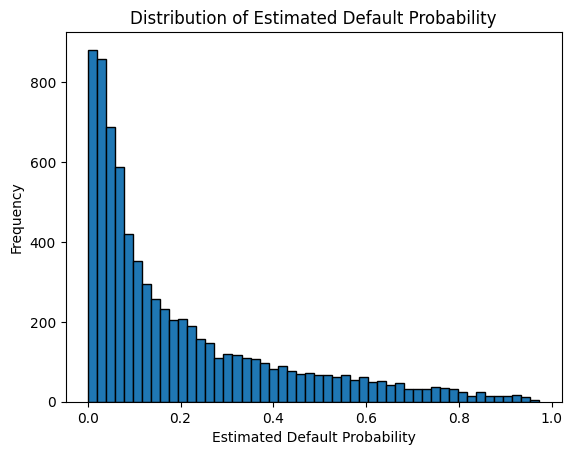

In [26]:
import matplotlib.pyplot as plt

# Histogram using matplotlib
plt.hist(df["PD"], bins=50, edgecolor="black")
plt.title("Distribution of Estimated Default Probability")
plt.xlabel("Estimated Default Probability")
plt.ylabel("Frequency")
plt.show()

Very skewed to the right.

## 4. Correlation

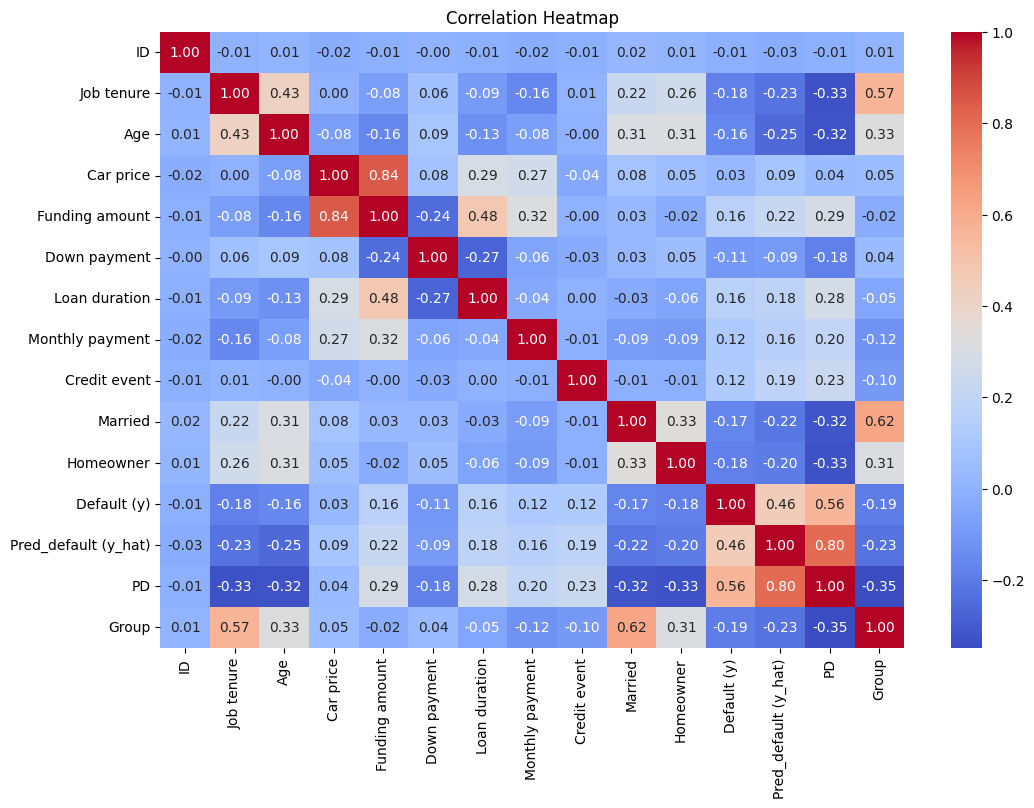

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Quite some correlated features:
- group + job tenure
- group + married
- homeowner + married
- loan duration + funding amount +  car price + monthly payment


We expect the features with the highest importance to be:
- job tenure
- age
- married
- homeowner
- group
- also loan duration and funding amount (but slightly less)

## 5. Multicollinearity

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
X = df.drop("PD", axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [
    variance_inflation_factor(X.values, i) for i in range(len(X.columns))
]

print(vif_data)

                 feature        VIF
0                     ID   3.592593
1             Job tenure   3.406223
2                    Age  10.183947
3              Car price  27.902986
4         Funding amount  30.490185
5           Down payment   1.657359
6          Loan duration   9.725592
7        Monthly payment   4.299240
8           Credit event   1.095462
9                Married   4.080311
10             Homeowner   2.007662
11           Default (y)   1.645297
12  Pred_default (y_hat)   1.624522
13                 Group   3.546720


Quite a few features have very high VIF values (age, car price, funding amount, loan duration) indicating that there is multicollinearity between our features. This means that we should prefer tree-based algorithms to a linear regression or logistic regression. If we do linear regression we should consider applying a ridge regression or lasso to remove some correlated features.

## 6. Check for Non-Linearity

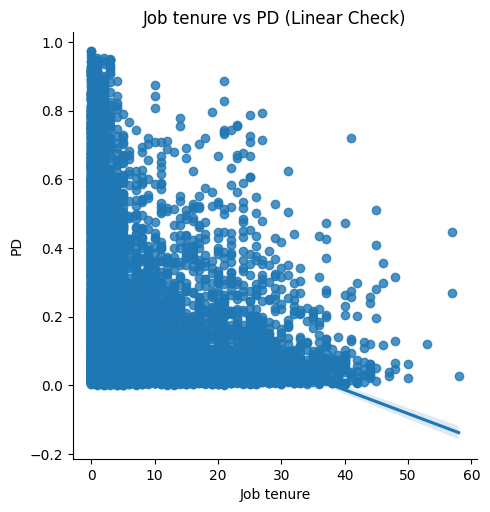

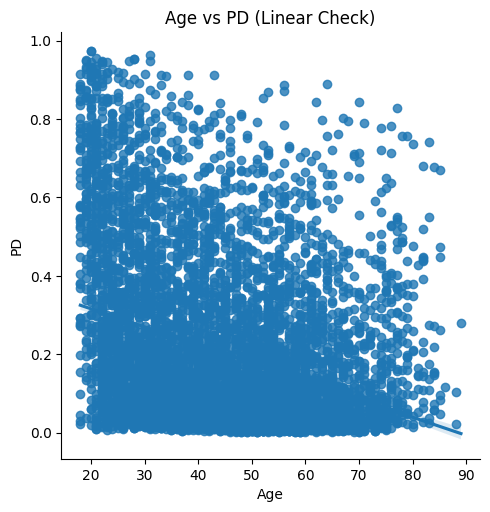

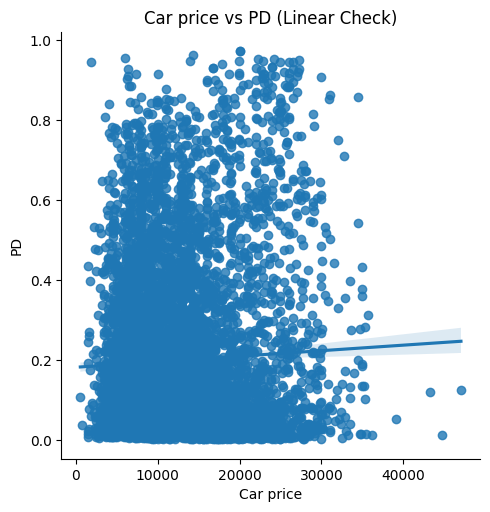

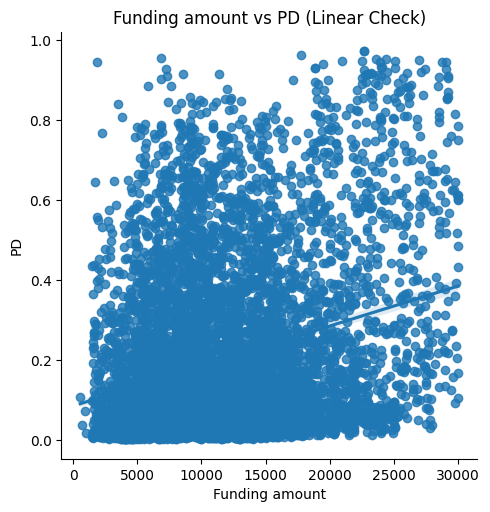

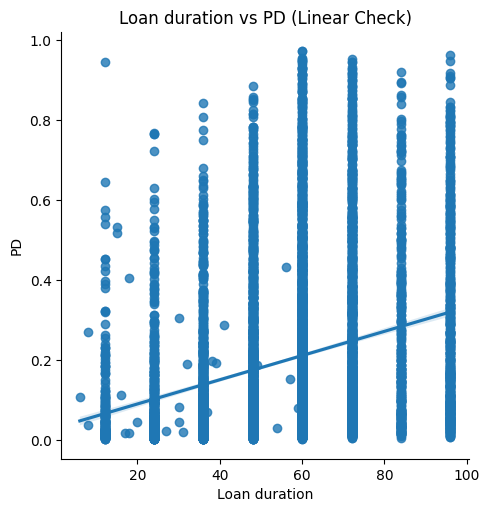

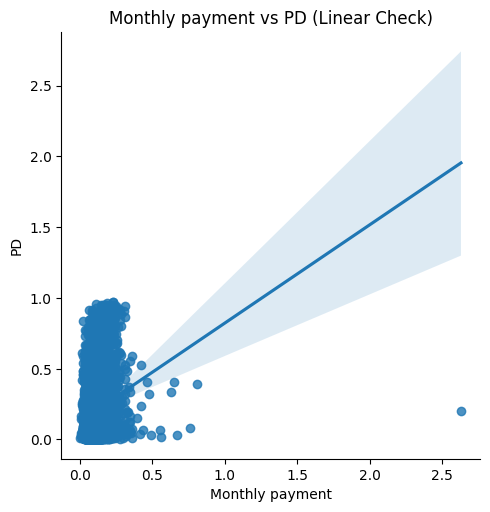

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check for linear relationships with scatterplots for continuous variables
for col in num_features:
    if col != "target":  # Ensure you're not plotting the target against itself
        sns.lmplot(x=col, y="PD", data=df)
        plt.title(f"{col} vs PD (Linear Check)")
        plt.show()

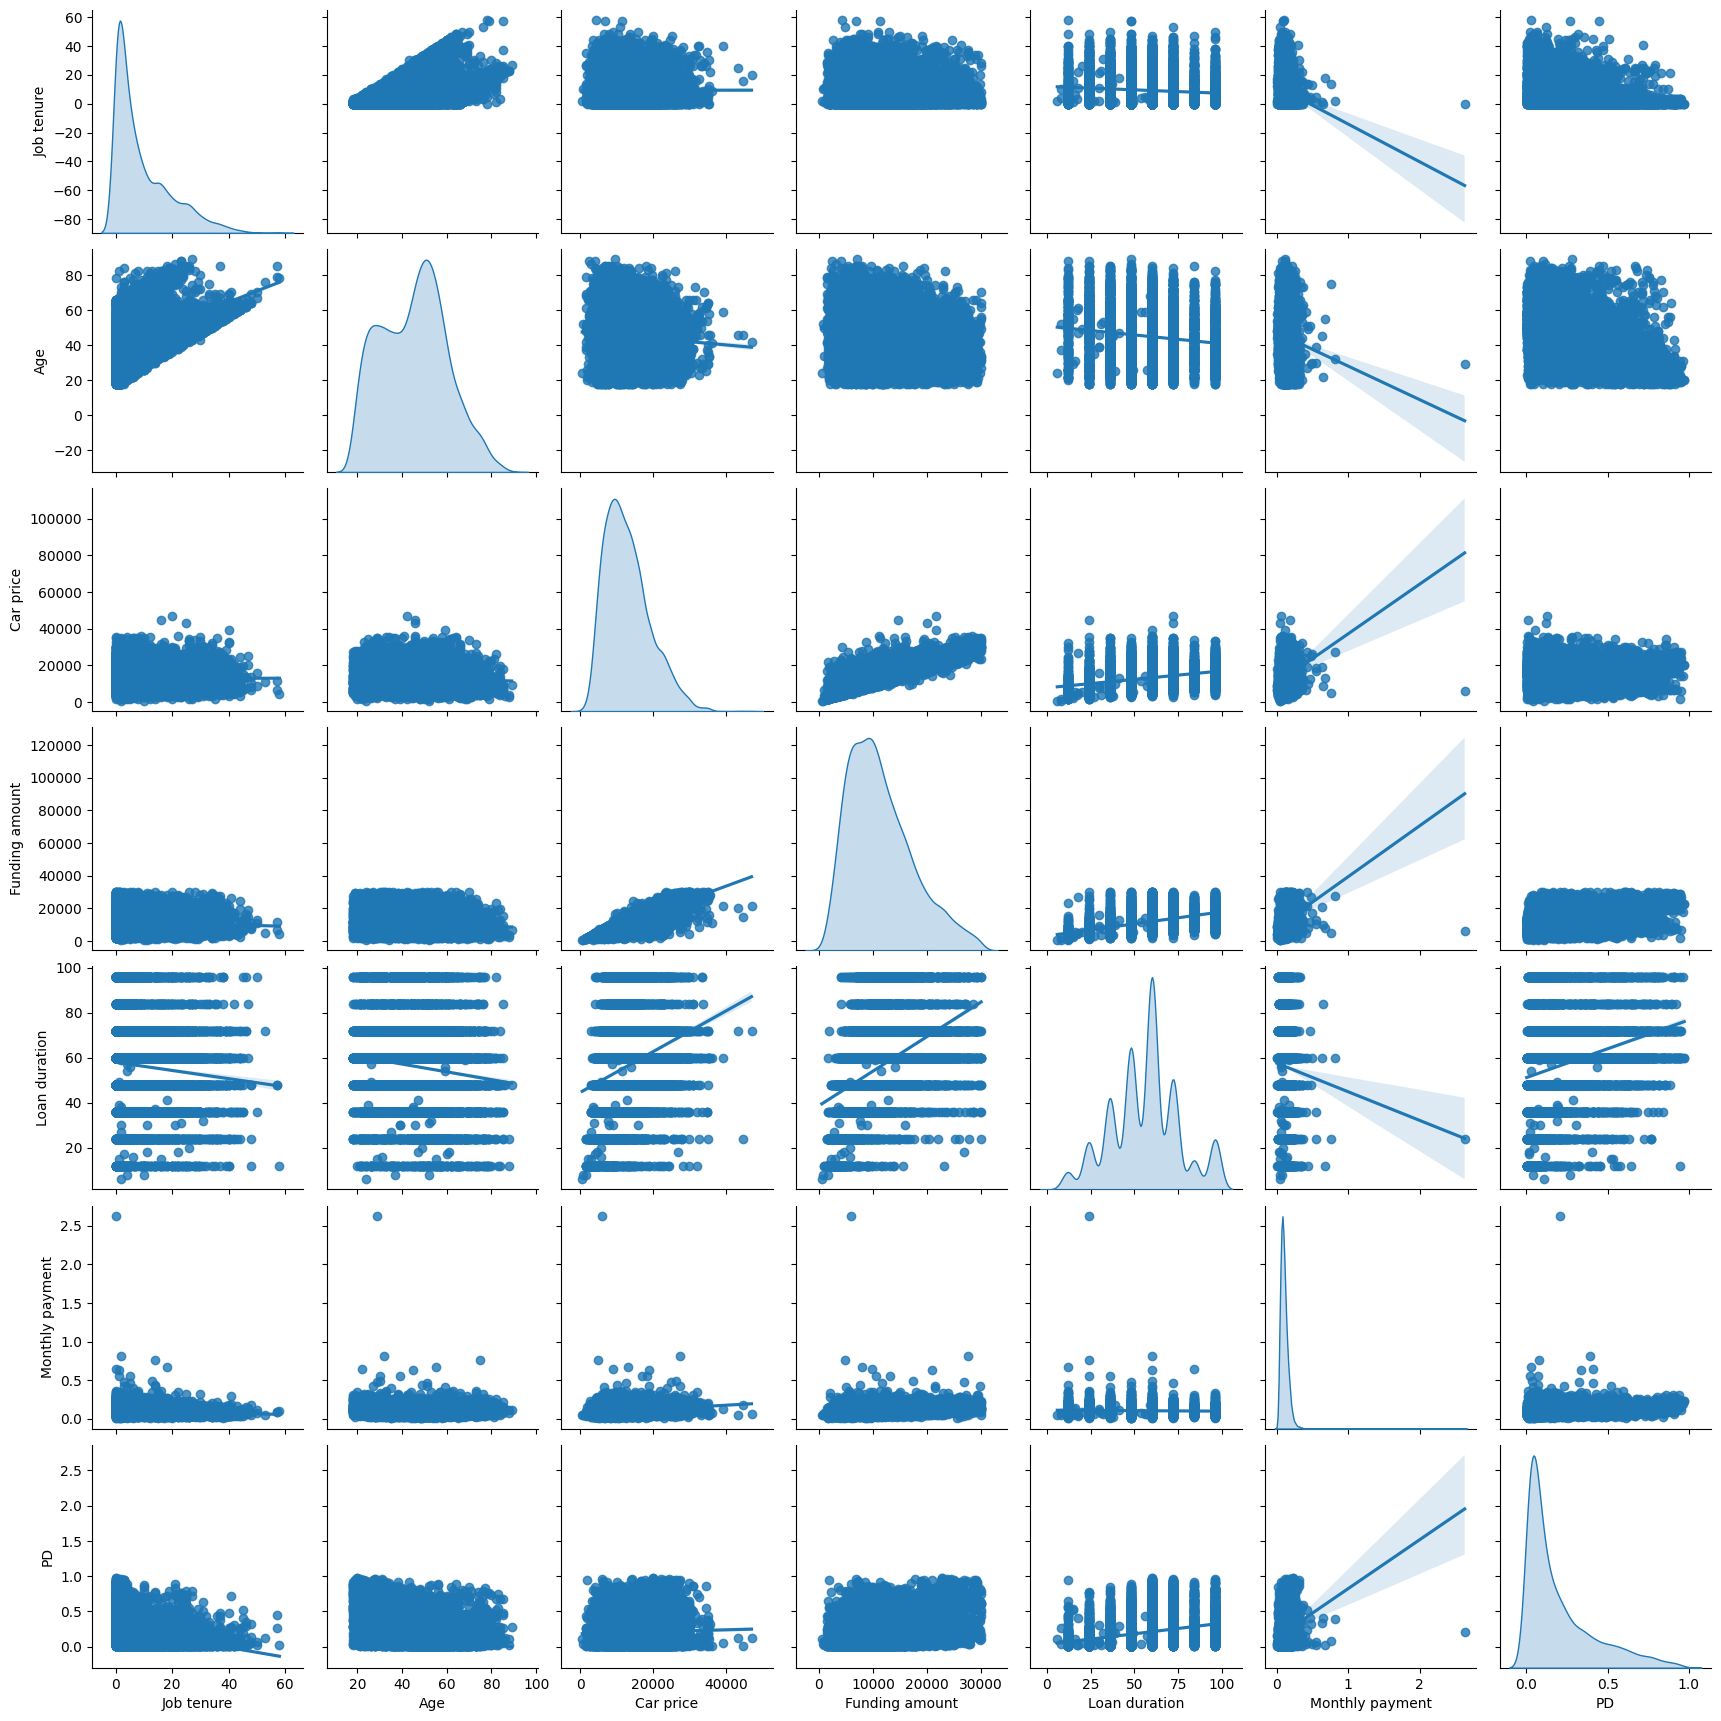

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# 1. Filter the DataFrame to include only numerical features
df_num = df[num_features + ["PD"]]  # Add 'PD' to include the target for pairplot

# 2. Pairplot to detect non-linear relationships among numerical features
sns.pairplot(df_num, diag_kind="kde", kind="reg")  # kind="reg" adds regression line
plt.show()

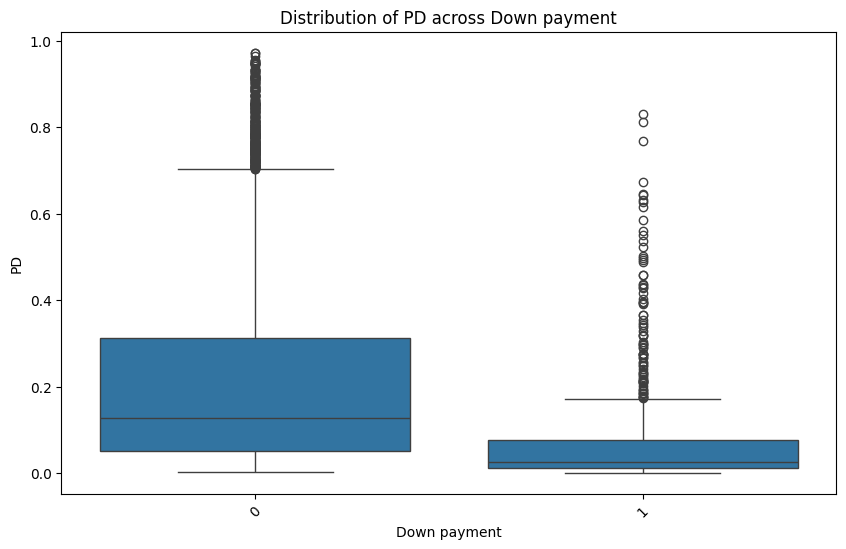

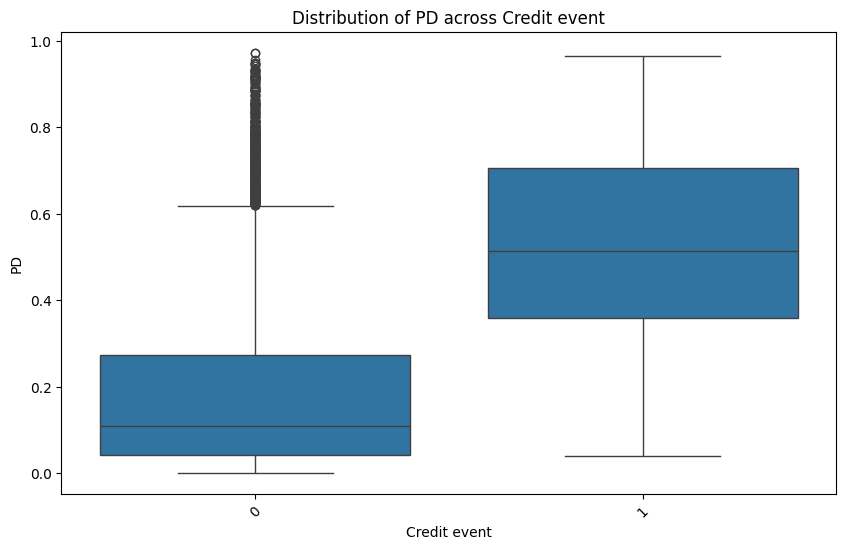

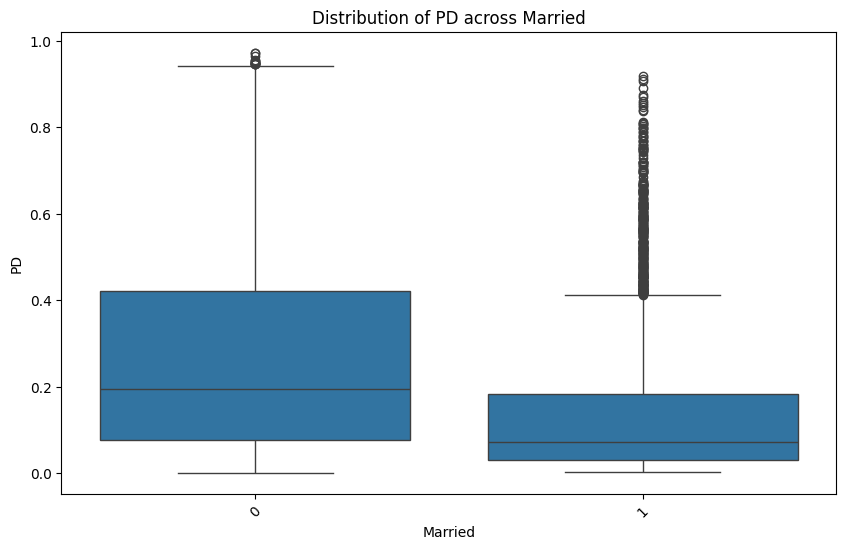

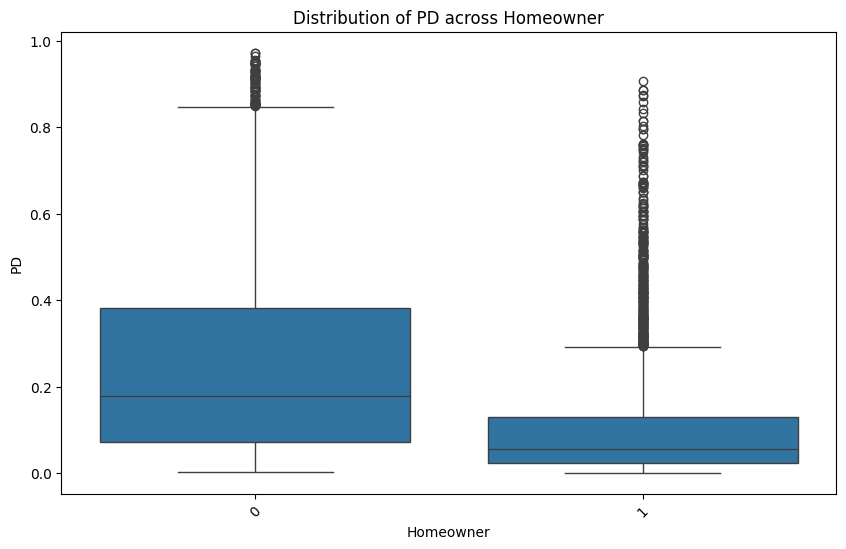

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Loop through each categorical feature and plot a boxplot for the target 'PD'
for feature in cat_features:
    plt.figure(figsize=(10, 6))  # Adjust figure size if needed
    sns.boxplot(x=feature, y="PD", data=df)
    plt.title(f"Distribution of PD across {feature}")
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.show()

For many of the categorical features there are large jumps in median value and differences in spreads and interquartile range. This indicates there could be non linear relationships.

## 7. Check for Outliers

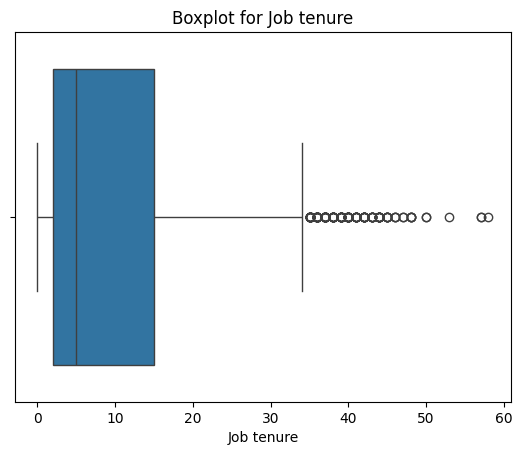

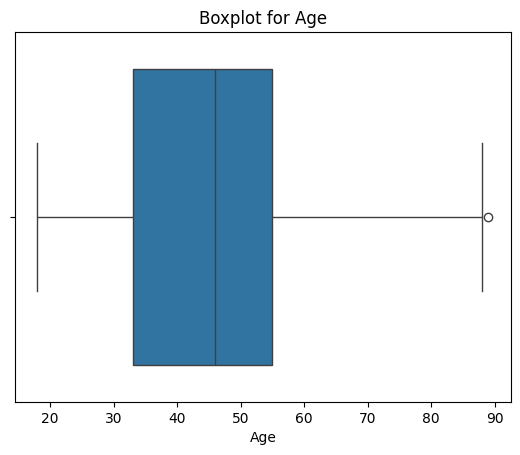

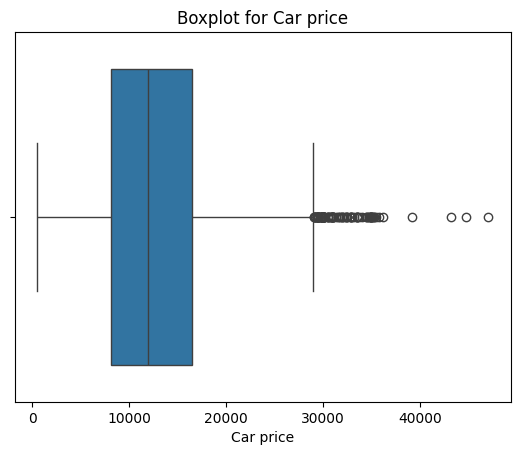

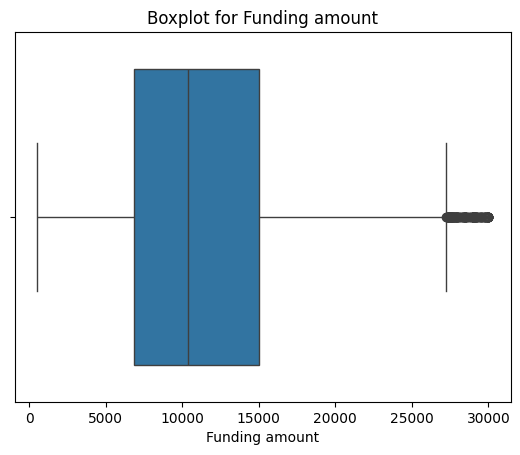

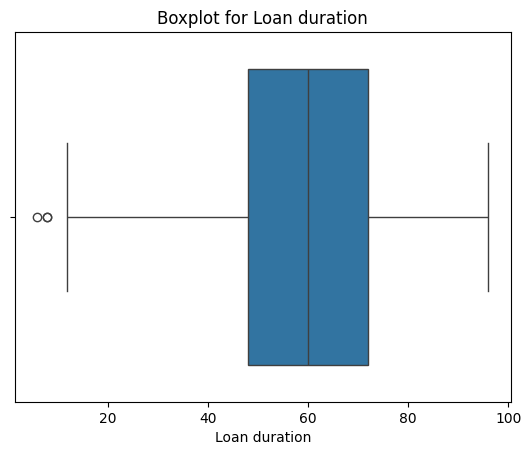

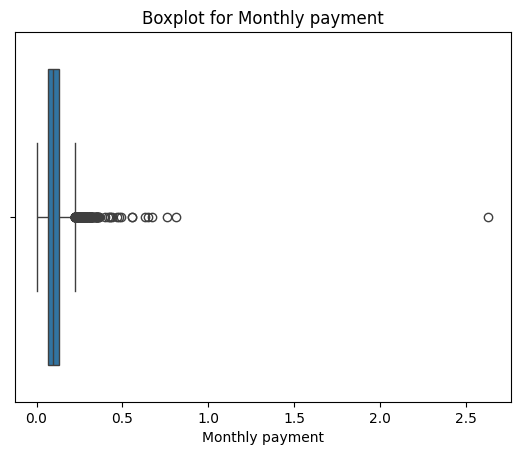

In [32]:
# Boxplot to detect outliers in continuous features
for col in num_features:
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot for {col}")
    plt.show()

There are some outliers. We should choose a model robust to this.

## 8. Check for Interactions

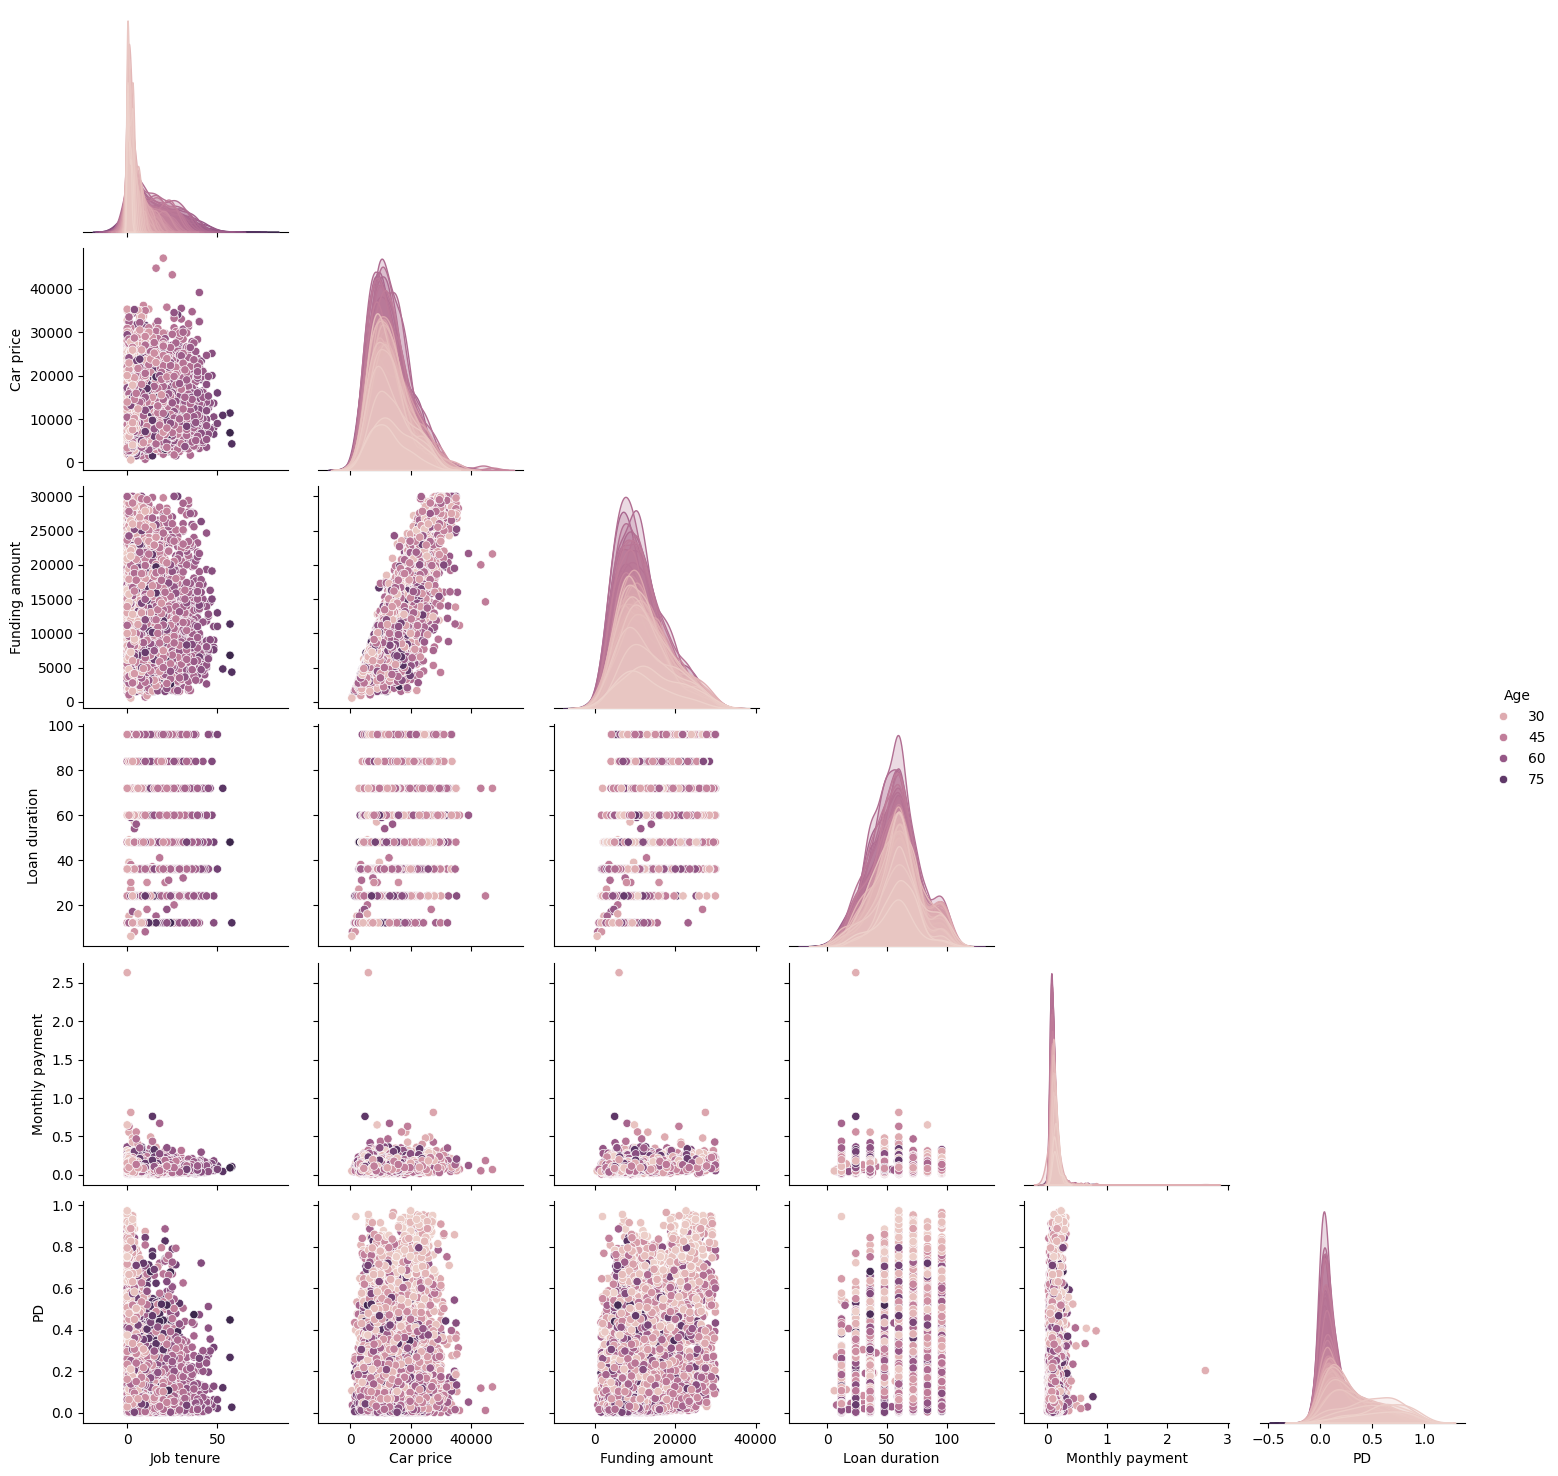

In [33]:
# Pairplot to detect potential interactions
sns.pairplot(df_num, hue="Age", corner=True)
plt.show()

There does seem to be interaction with age for several features like job tenure, car price, funding amount.

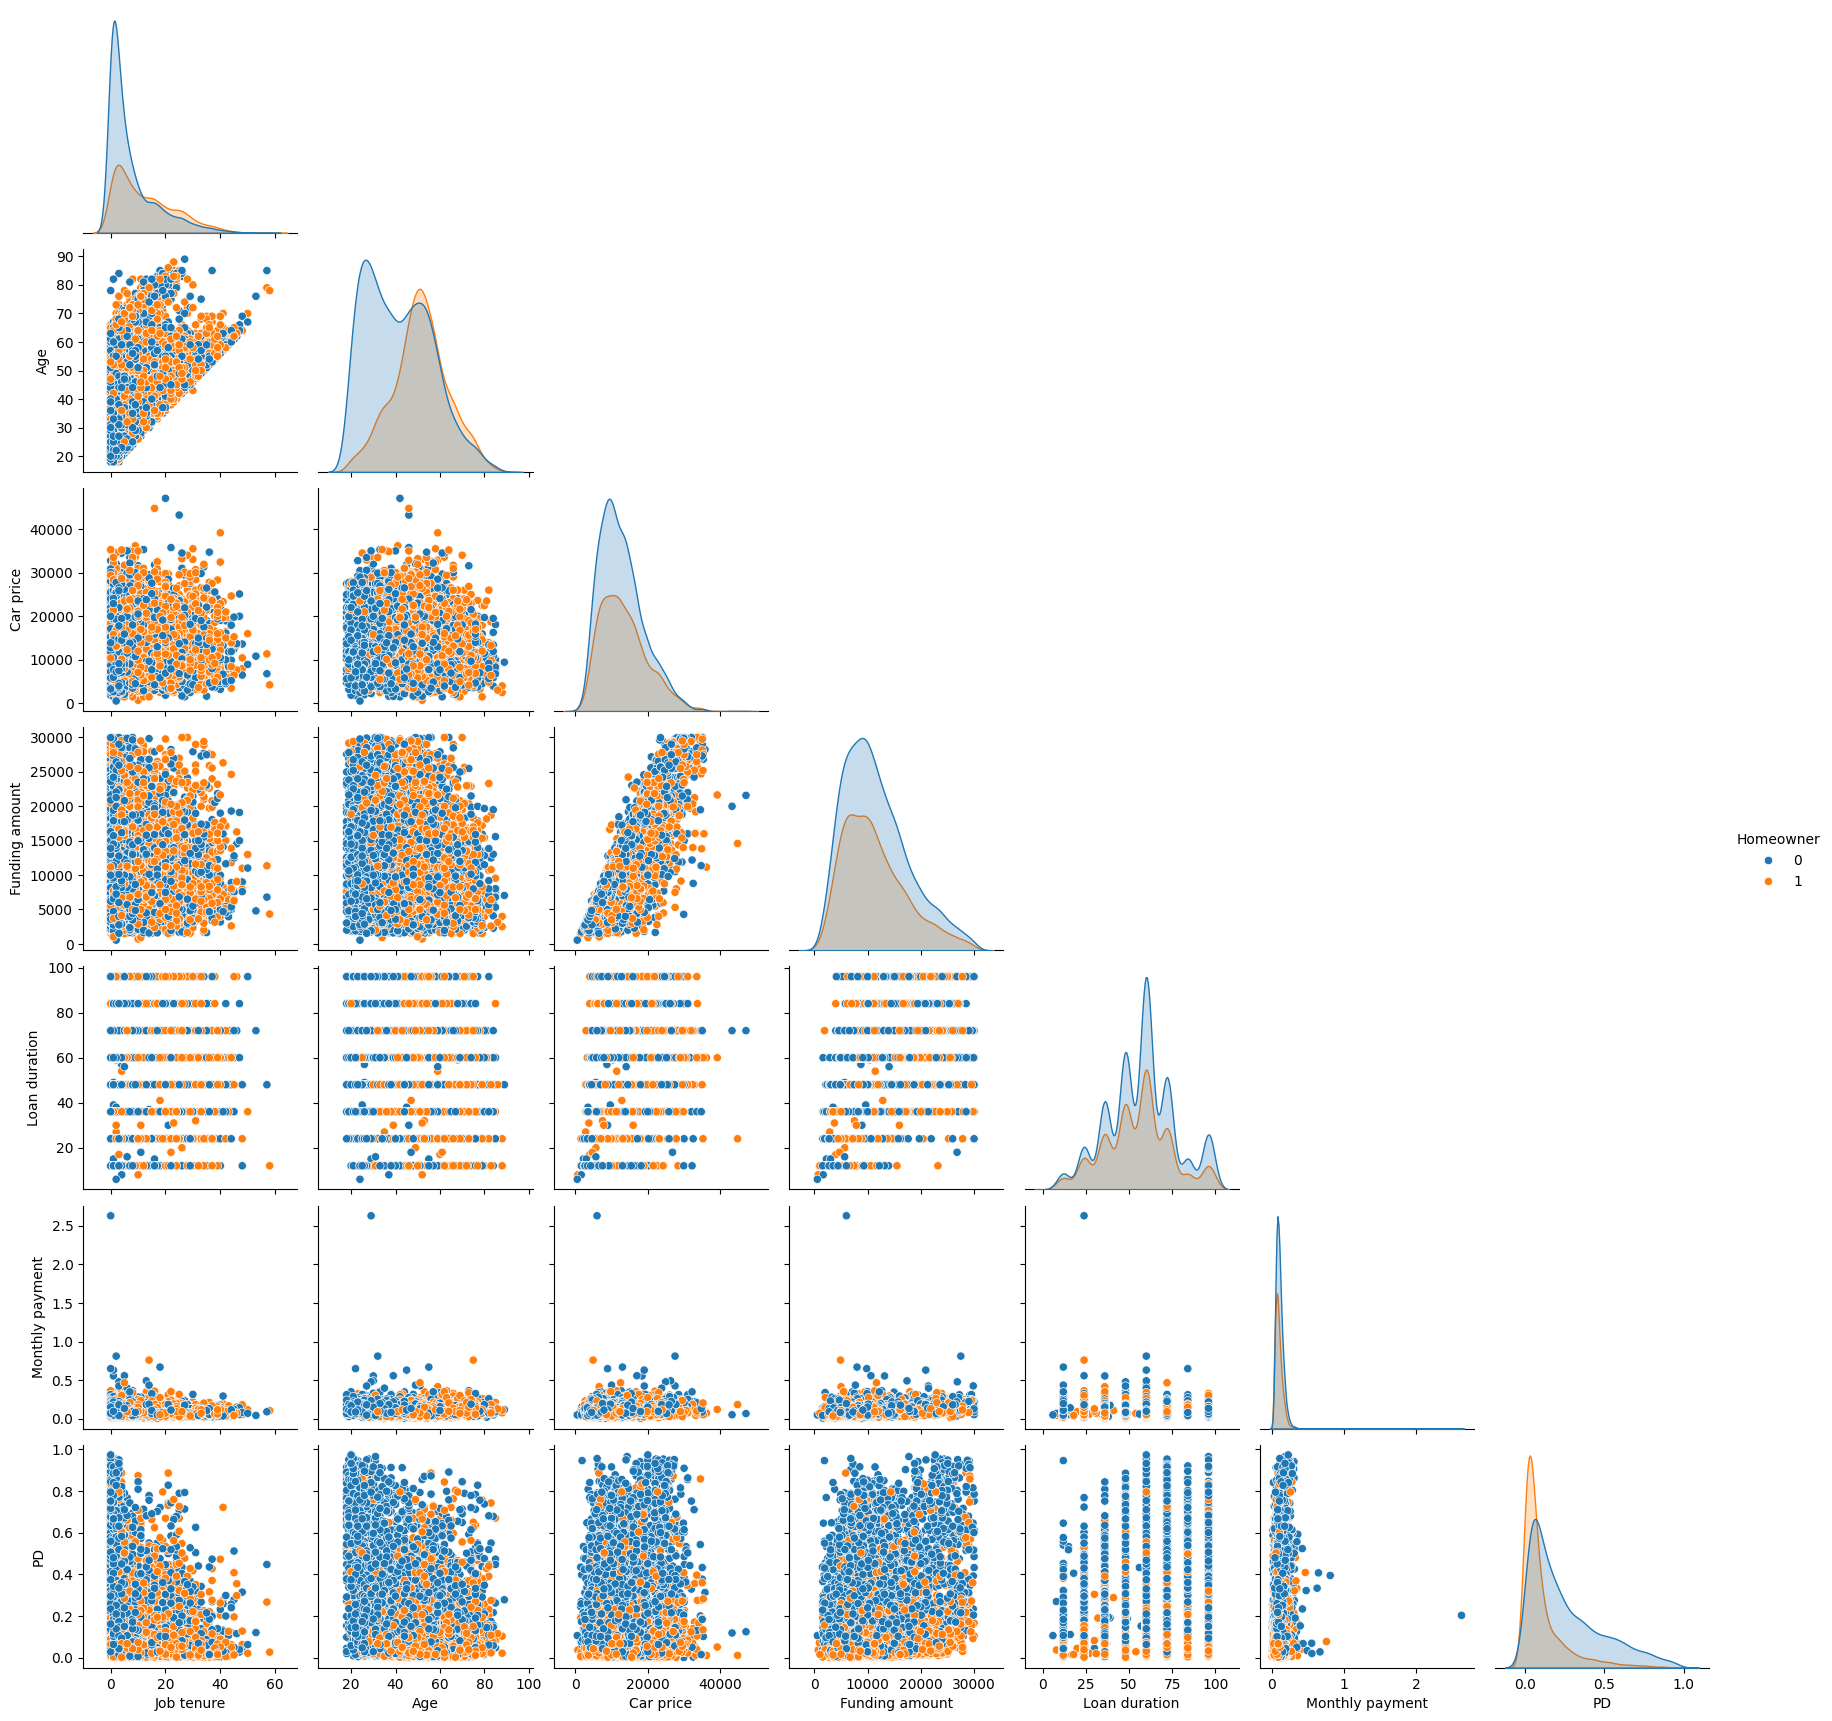

In [34]:
# Pairplot to detect potential interactions
sns.pairplot(df[list(df_num.columns) + ["Homeowner"]], hue="Homeowner", corner=True)
plt.show()

## 9. Check for class imbalance

In [35]:
# Get the ratio of classes
class_counts = df["Default (y)"].value_counts(normalize=True) * 100
print(f"Class balance:\n{class_counts}")

Class balance:
Default (y)
0    80.013459
1    19.986541
Name: proportion, dtype: float64


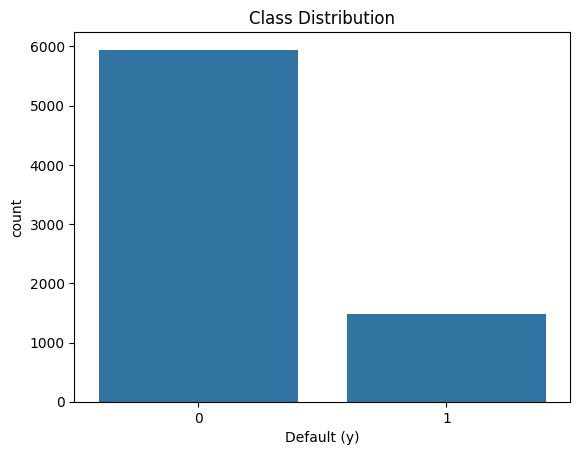

In [36]:
sns.countplot(x="Default (y)", data=df)
plt.title("Class Distribution")
plt.show()

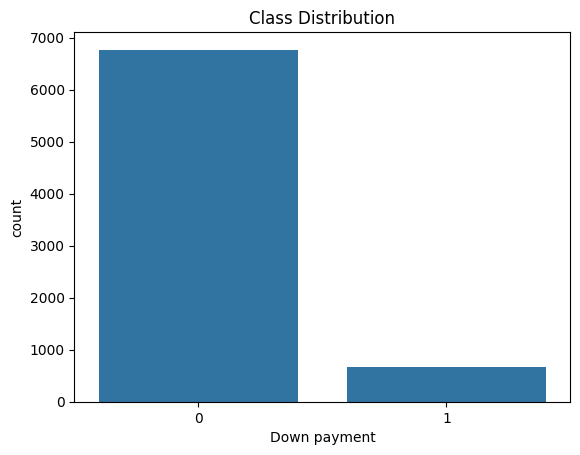

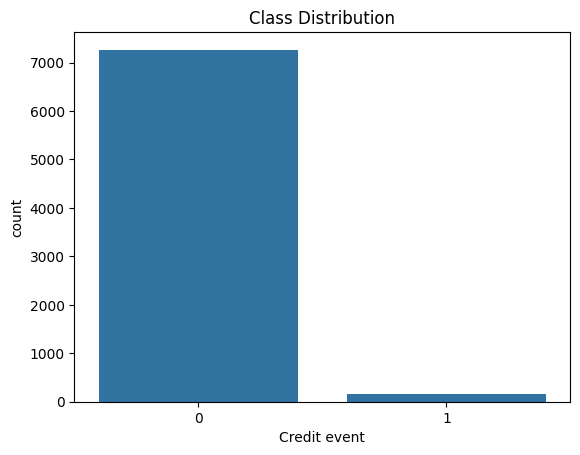

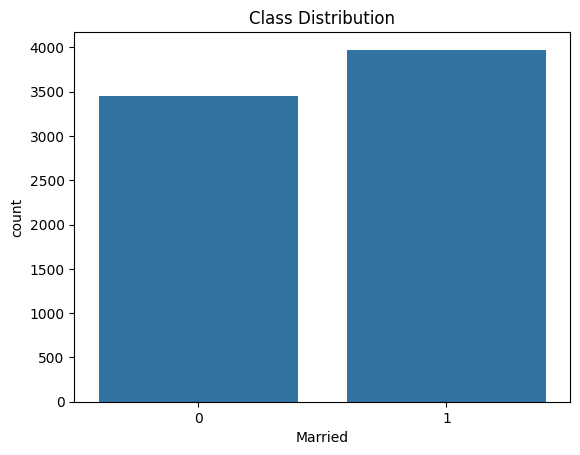

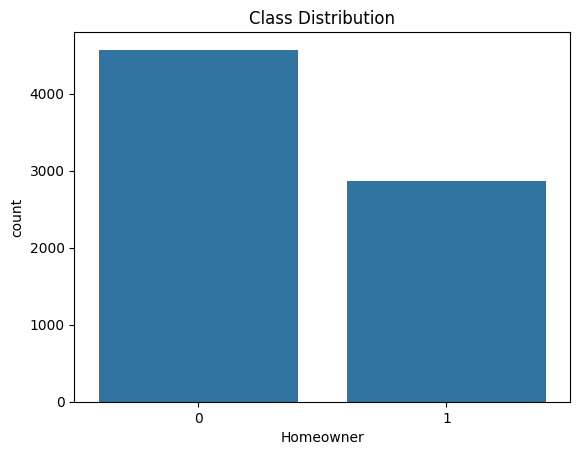

In [37]:
# Check for class imbalance
for feature in cat_features:
    sns.countplot(x=feature, data=df)
    plt.title("Class Distribution")
    plt.show()

# Step 1: Decision Tree Surrogate Model

In [38]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

# Defining features (X) and target (y)
X = df[
    [
        "Job tenure",
        "Age",
        "Car price",
        "Funding amount",
        "Down payment",
        "Loan duration",
        "Monthly payment",
        "Credit event",
        "Married",
        "Homeowner",
    ]
]
y = df["PD"]

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Decision Tree model
tree = DecisionTreeRegressor(random_state=42, max_depth=3)
tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, random_state=42)

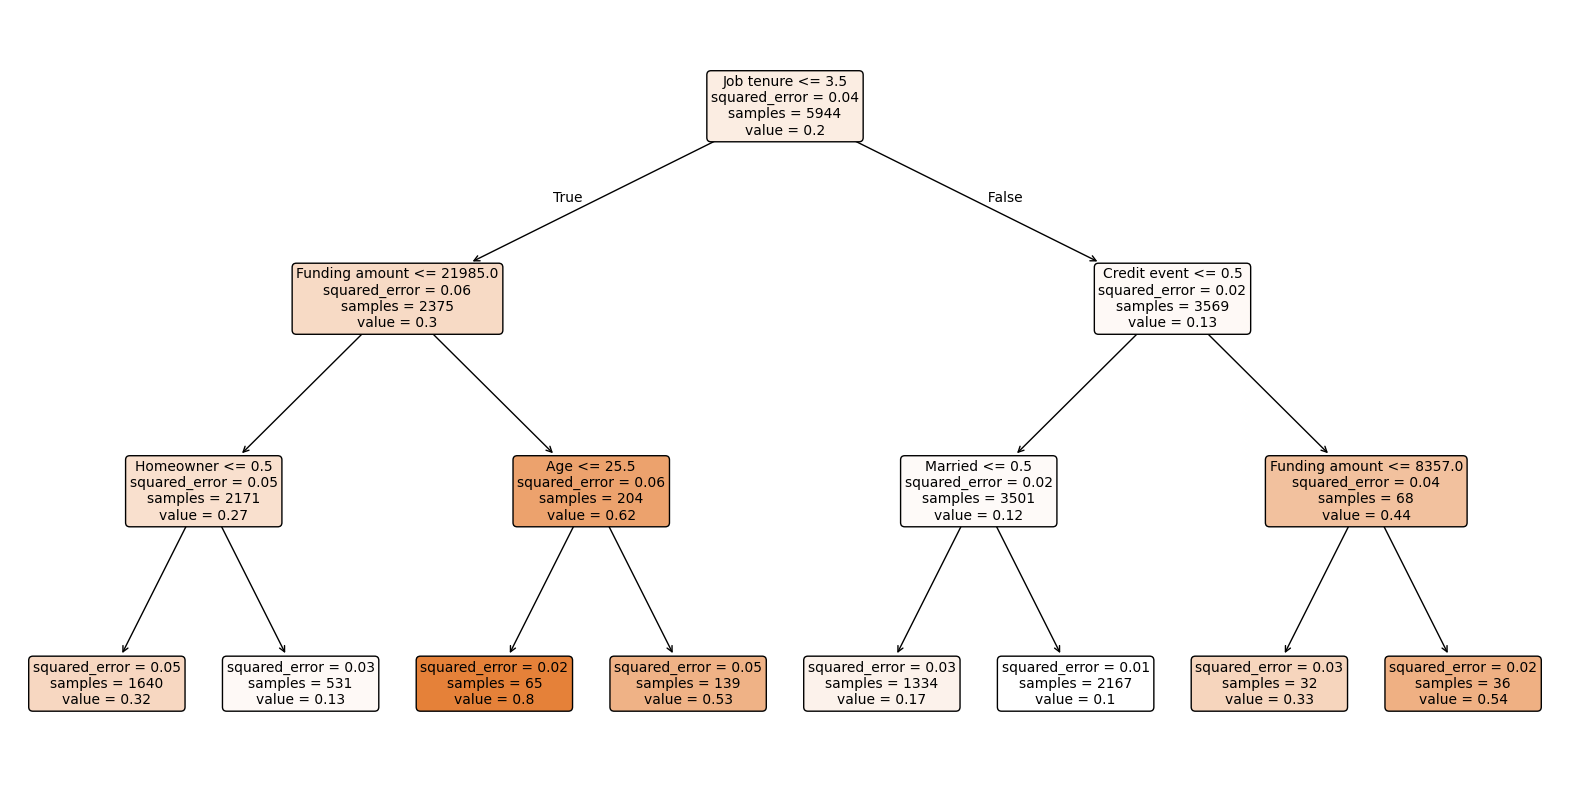

In [39]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Set up the plot size (adjust as needed)
plt.figure(figsize=(20, 10))

# Plot the tree with decision rules displayed
plot_tree(
    tree,
    filled=True,
    feature_names=X.columns,
    rounded=True,
    precision=2,  # Display numerical precision
    proportion=False,  # False means we will show the sample count, not proportion
    fontsize=10,  # Adjust font size for readability
    impurity=True,  # Show impurity (Gini or Entropy)
    class_names=True,
)  # Show class names if available

# Show the plot
plt.show()

In [40]:
from sklearn.tree import export_text

# Print the decision rules in text format
tree_rules = export_text(tree, feature_names=list(X.columns))
print(tree_rules)

|--- Job tenure <= 3.50
|   |--- Funding amount <= 21985.00
|   |   |--- Homeowner <= 0.50
|   |   |   |--- value: [0.32]
|   |   |--- Homeowner >  0.50
|   |   |   |--- value: [0.13]
|   |--- Funding amount >  21985.00
|   |   |--- Age <= 25.50
|   |   |   |--- value: [0.80]
|   |   |--- Age >  25.50
|   |   |   |--- value: [0.53]
|--- Job tenure >  3.50
|   |--- Credit event <= 0.50
|   |   |--- Married <= 0.50
|   |   |   |--- value: [0.17]
|   |   |--- Married >  0.50
|   |   |   |--- value: [0.10]
|   |--- Credit event >  0.50
|   |   |--- Funding amount <= 8357.00
|   |   |   |--- value: [0.33]
|   |   |--- Funding amount >  8357.00
|   |   |   |--- value: [0.54]



In [41]:
# Predicting on the test set for both models
y_pred_tree = tree.predict(X_test)

Decision Tree - MSE: 0.030299016578028446, MAE: 0.12876413429915398, R²: 0.30911991669819894
Feature Importance from Decision Tree: [0.45362081 0.0355337  0.         0.24319809 0.         0.
 0.         0.07258665 0.04343492 0.15162584]


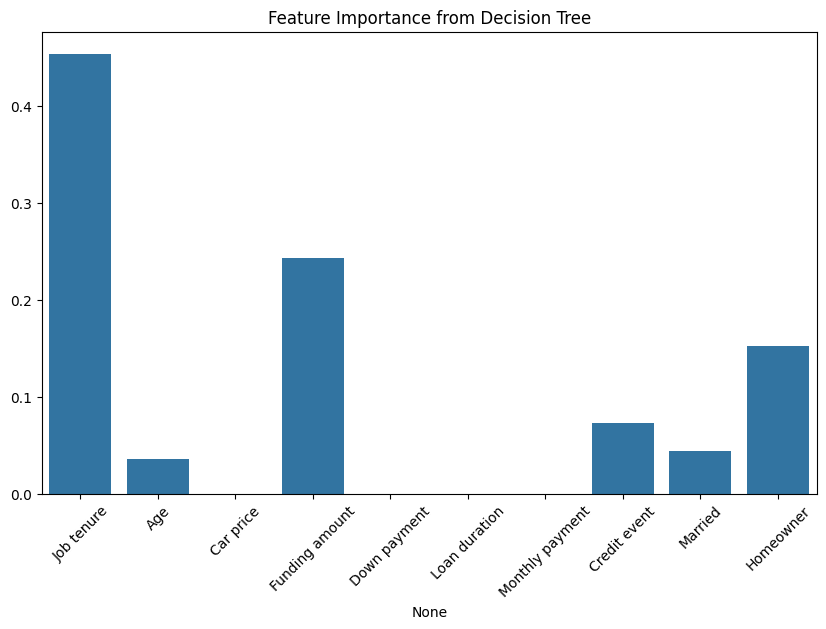

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns

# Calculating the Mean Squared Error for both models
mse_tree = mean_squared_error(y_test, y_pred_tree)
mae_tree = mean_absolute_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

# Checking feature importance for Decision Tree
tree_feature_importance = tree.feature_importances_

# Output the MSE and feature importance for Decision Tree
print(f"Decision Tree - MSE: {mse_tree}, MAE: {mae_tree}, R²: {r2_tree}")
print("Feature Importance from Decision Tree:", tree_feature_importance)

# Visualization of Decision Tree feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=X.columns, y=tree_feature_importance)
plt.title("Feature Importance from Decision Tree")
plt.xticks(rotation=45)
plt.show()

- MSE: The MSE is 0.02379, which indicates how well the surrogate model approximates the unknown model's output. The lower the MSE, the better the approximation. Here it is quite low, so the model seems to fit the data well.

- Feature Importance: The feature importance from the surrogate model shows which features are driving the predictions of the unknown model. From the provided bar chart, it can be sees that:
    - Funding amount and Job tenure have the highest importance, which suggests that these features have a significant influence on the PD.
    - Age and Car price are also important features but to a lesser extent.
    - Features like Loan duration, Monthly payment, and Homeowner contribute moderately to the model.

We get very different results in terms of feature importance between the decision tree surrogate model and the linear regression surrogate model. This is to be expected as they are 2 models which work very differently. Most importantly, the linear regression surrogate model does not take into account non-linear relationships between the features in the target variable. Given our EDA we find non-linear relationships in our data and thus trust the decision tree surrogate model more.


Comparing the metrics of the 2 surrogate models we notice that the decision tree always gives better results, further confirming our conclusion.

# Step 7: SHAP method

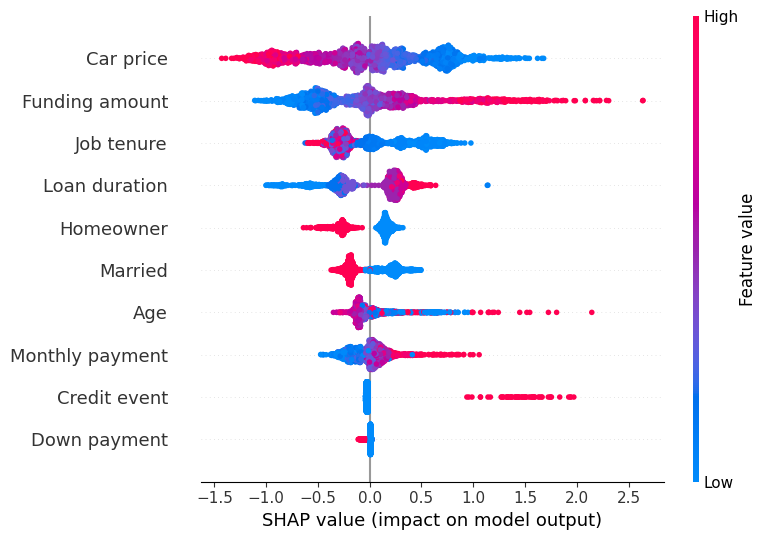

In [ ]:
import shap

# Initialize SHAP Tree Explainer
explainer = shap.TreeExplainer(model)

# Get SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test)

<Figure size 640x480 with 0 Axes>

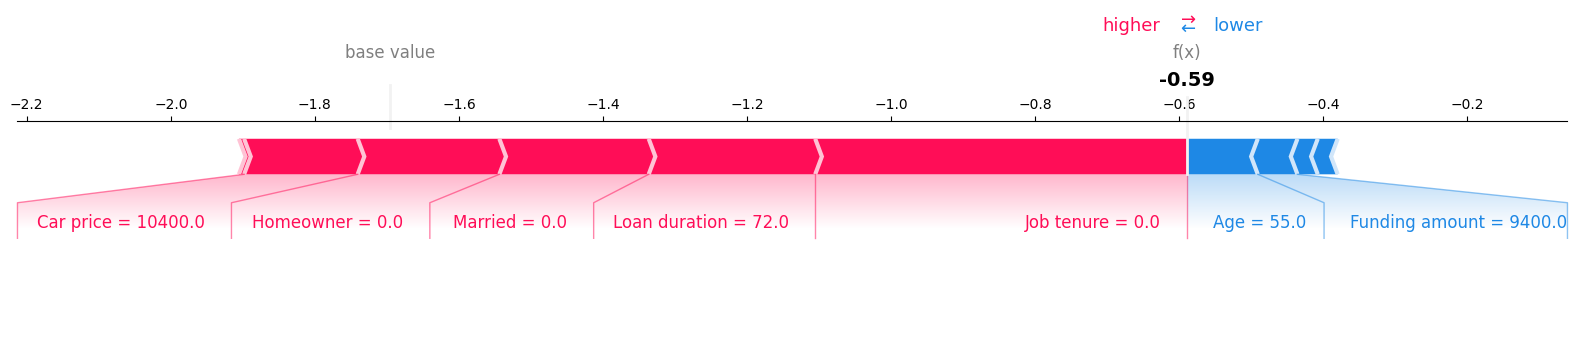

In [ ]:
import matplotlib.pyplot as plt

# Initialize the JavaScript visualization library
# shap.initjs()

# Force plot for a single prediction (e.g., first instance in the test set)
# shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])

# Create a figure and save it using matplotlib's savefig function
plt.figure()
shap.force_plot(explainer.expected_value, shap_values[1], X_test.iloc[1], matplotlib=True)

<Figure size 640x480 with 0 Axes>

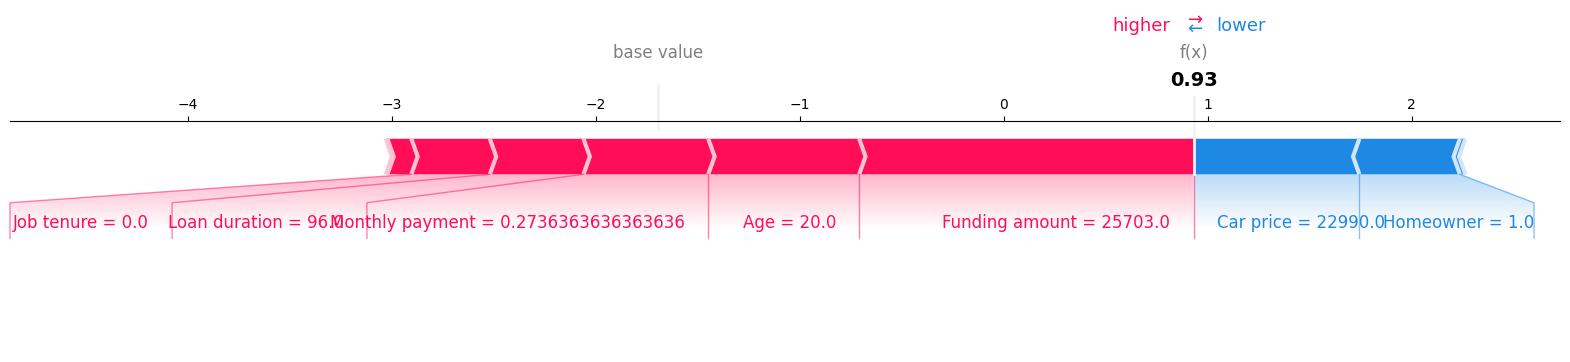

In [ ]:
# Create a figure and save it using matplotlib's savefig function
plt.figure()
shap.force_plot(explainer.expected_value, shap_values[9], X_test.iloc[9], matplotlib=True)

<Figure size 640x480 with 0 Axes>

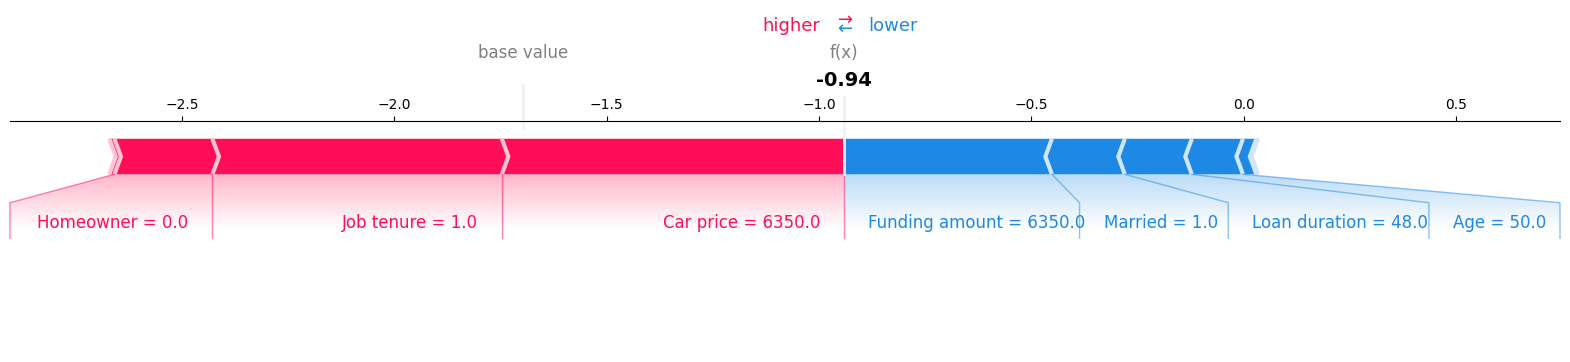

In [ ]:
# Create a figure and save it using matplotlib's savefig function
plt.figure()
shap.force_plot(explainer.expected_value, shap_values[15], X_test.iloc[15], matplotlib=True)

# Step 8: Performance Interpretability

## 1. XPER

We are going to end up with an AUC of 0.76/0.80 do not try to improve it much more (for the black box model).

Sample 500 random values from X_test and get the corresponding y_test values:

In [ ]:
# Generate a list of random indices
random_indices = np.random.choice(len(X_test), size=500, replace=False)

# Select the corresponding samples from X_test and y_test
X_test_sampled = X_test.iloc[random_indices]
y_test_sampled = y_test.iloc[random_indices]

In [ ]:
import XPER
from XPER.compute.Performance import ModelPerformance

# Define the evaluation metric(s) to be used
XPER = ModelPerformance(X_train.values, 
                        y_train.values, 
                        X_test_sampled.values, 
                        y_test_sampled.values, 
                        model)

# Evaluate the model performance using the specified metric(s)
PM_auc = XPER.evaluate(["AUC"])
PM_ba = XPER.evaluate(["Balanced_accuracy"])

# Print the performance metrics
print("Performance Metrics: ")
print("AUC: ", round(PM_auc, 3))
print("Balanced accuracy: ", round(PM_ba, 3))

Performance Metrics: 
AUC:  0.783
Balanced accuracy:  0.616


In [ ]:
# Calculate XPER values for the model's performance
XPER_values = XPER.calculate_XPER_values(["Balanced_accuracy"], kernel=True, N_coalition_sampled=10) # takes 48 min

Performing Computation:   0%|          | 0/1 [00:00<?, ?it/s]

10


Performing Computation: 100%|██████████| 1/1 [00:37<00:00, 37.25s/it]


In [ ]:
np.savez('data/XPER_values_ba.npz', array1=XPER_values[0], array2=XPER_values[1])

In [ ]:
from XPER.viz.Visualisation import visualizationClass as viz

labels = list(X.columns)

In [ ]:
viz.bar_plot(XPER_values=XPER_values, X_test=X_test, labels=labels, p=10, percentage=True)

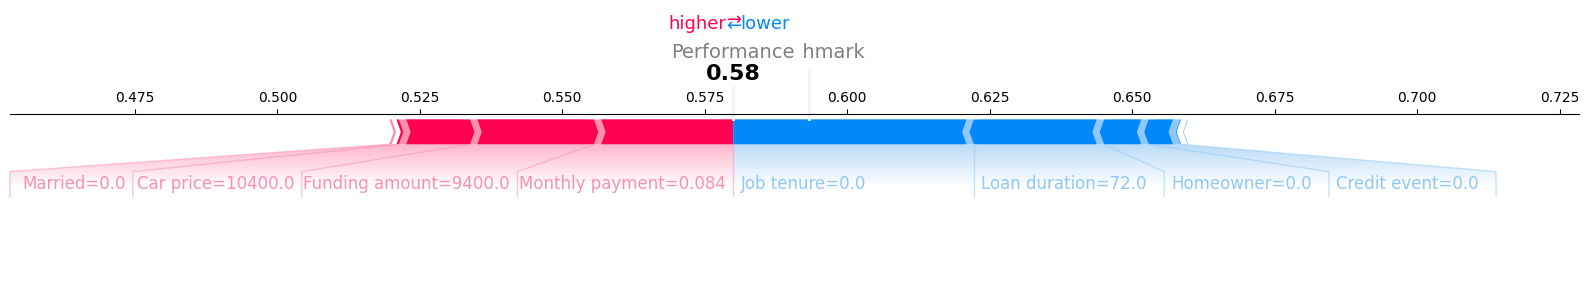

In [ ]:
viz.force_plot(XPER_values=XPER_values, instance=1, X_test=X_test, variable_name=labels, figsize=(16,4))

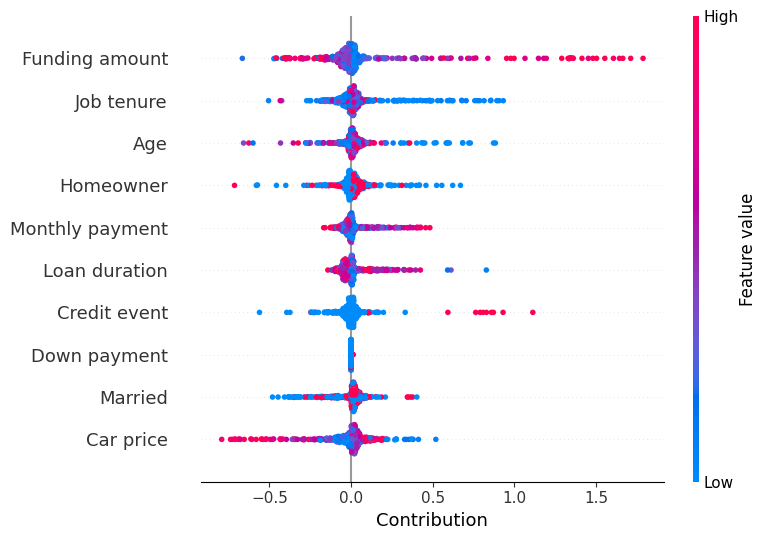

In [ ]:
# Will only work once we 
viz.beeswarn_plot(XPER_values=XPER_values, X_test=X_test_sampled, labels=labels)

## 2. Permutation Importance

In [ ]:
from sklearn.inspection import permutation_importance

r = permutation_importance(model, X, y,
                           n_repeats=30,
                           random_state=0,
                           scoring='balanced_accuracy')

Only features with a significant contribution (where the mean importance minus two standard deviations is positive) are printed.

In [ ]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X.columns[i]}: "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

Funding amount: 0.046 +/- 0.005
Job tenure: 0.042 +/- 0.003
Monthly payment: 0.032 +/- 0.002
Age: 0.022 +/- 0.002
Homeowner: 0.019 +/- 0.002
Credit event: 0.014 +/- 0.002
Loan duration: 0.011 +/- 0.003


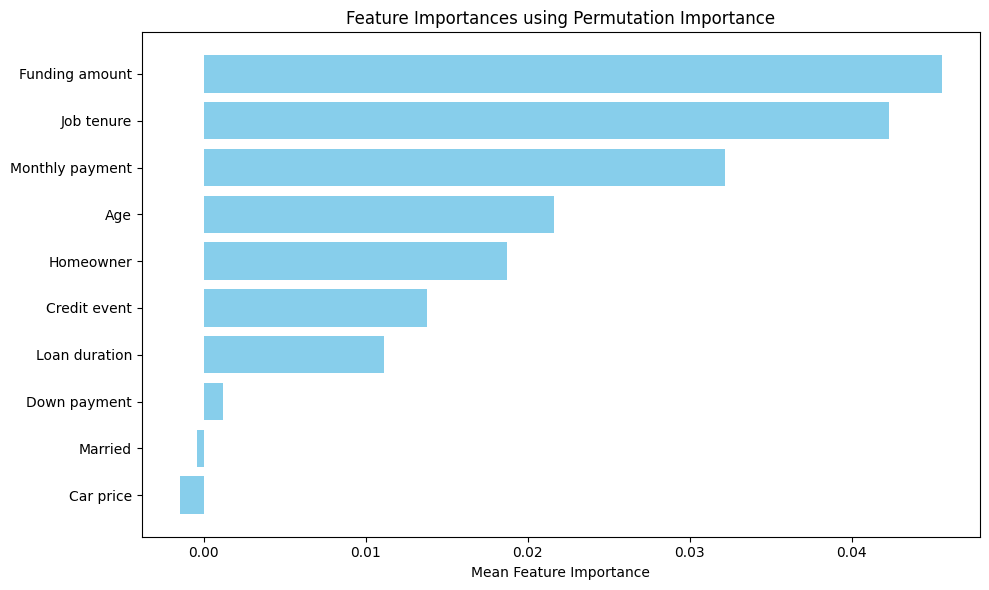

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assume X_val.columns contains the feature names, and r.importances_mean contains the importances
# Sorting features by importance
sorted_idx = np.argsort(r.importances_mean)

# Plotting horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], r.importances_mean[sorted_idx], color='skyblue')

# Adding labels and title
plt.xlabel('Mean Feature Importance')
plt.title('Feature Importances using Permutation Importance')
plt.show()
